# 2D cell tracking with Ultrack and MicroSAM

This notebook shows how Ultrack can be combined with [MicroSAM](https://github.com/computational-cell-analytics/micro-sam) to track multiple cells.

Ultrack's capability to allow multiple candidate segmentation and [SAM](https://github.com/facebookresearch/segment-anything)'s ability to predict multiple possible segments allows them to be very effective together.

First, we download the sample data from the [cell-tracking challenge](celltrackingchallenge.net/).

In [1]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip
!unzip -n Fluo-N2DL-HeLa.zip

File ‘Fluo-N2DL-HeLa.zip’ already there; not retrieving.

Archive:  Fluo-N2DL-HeLa.zip


Next, we import the required packages. We are using our wrapper of the original MicroSAM package.

In [2]:
from pathlib import Path

import napari
from rich import print
from napari.utils.notebook_display import nbscreenshot

from ultrack import MainConfig, track, to_tracks_layer, tracks_to_zarr
from ultrack.utils.array import array_apply, create_zarr
from ultrack.imgproc import normalize
from ultrack.imgproc.sam import MicroSAM, set_peak_maxima_prompt
from ultrack.utils.cuda import import_module, to_cpu, on_gpu, torch_default_device

We open the image using napari.

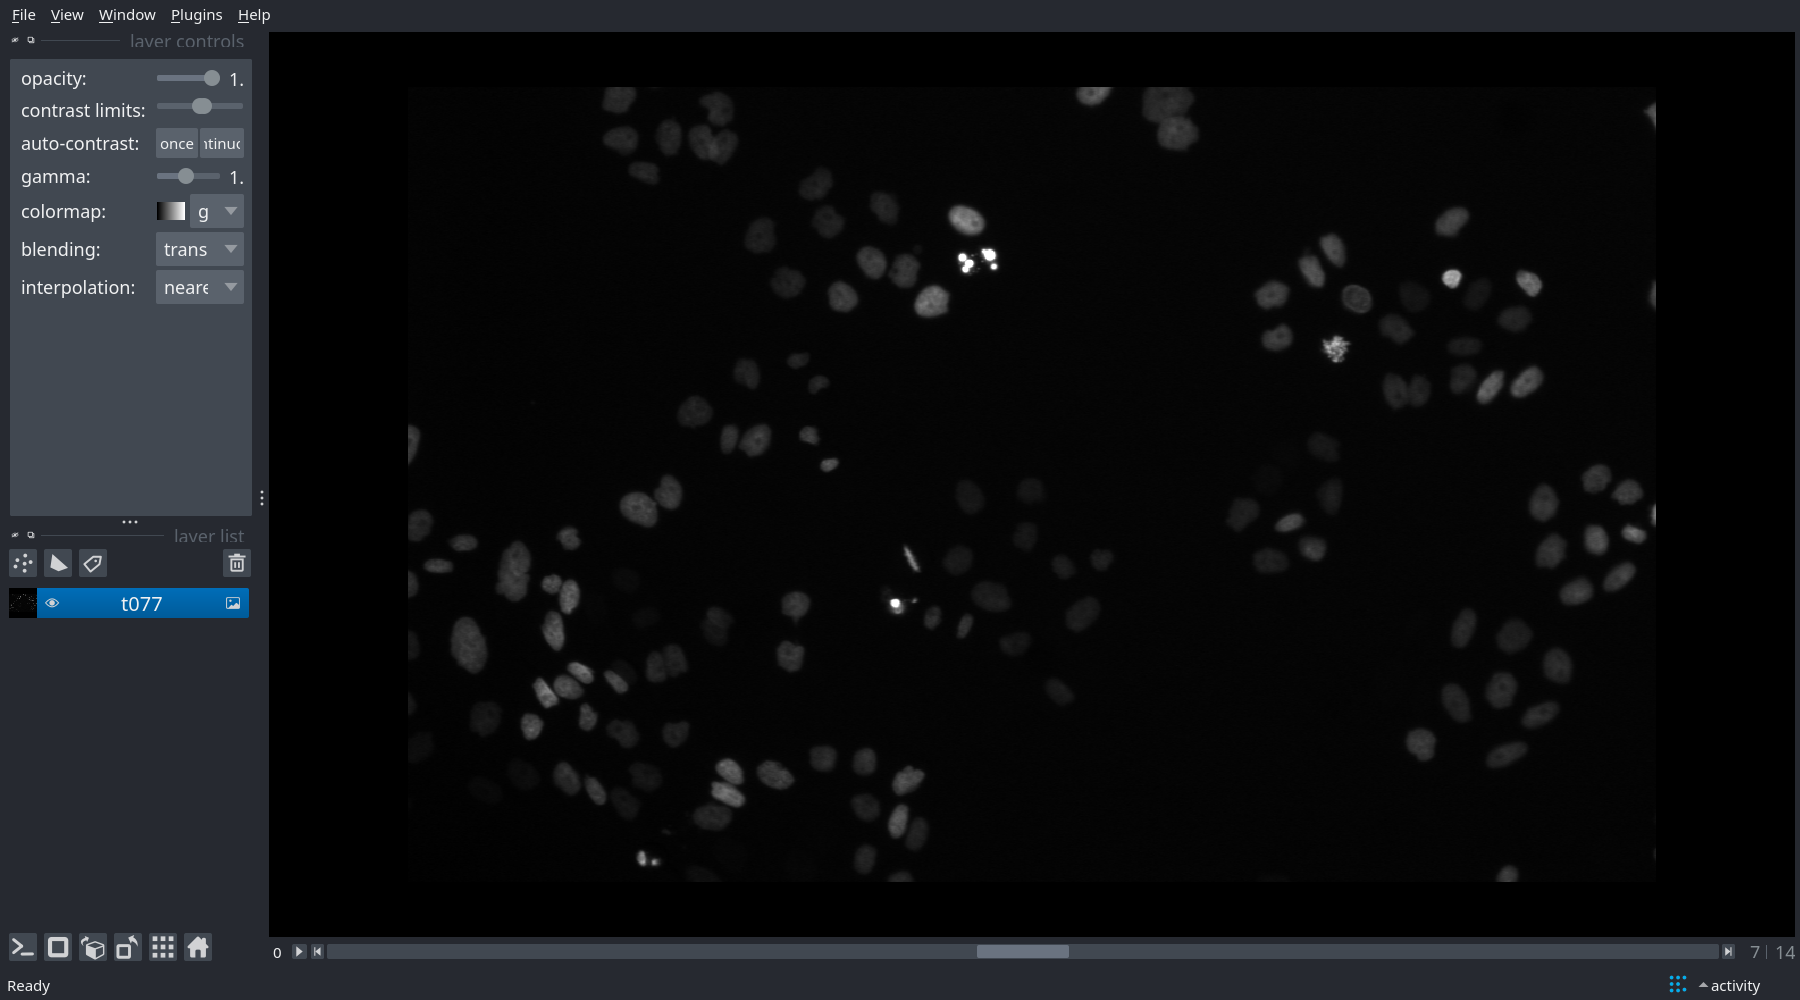

In [3]:
dataset_path = Path("Fluo-N2DL-HeLa/01")
image_files = list(sorted(dataset_path.glob("*.tif")))
image_files = image_files[-15:]  # uncomment to process the whole dataset

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(image_files, stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

Ultrack expects a detection (foreground vs background) and a cell contour map as input. Our `MicroSAM` wrapper assists in obtaining that.

Even though SAM has an automatic segmentation functionality, it does that by querying points in a uniform grid over the image and selecting them by estimating their segmentation quality. However, this can be time-consuming and missing several cells, so we provide a `set_peak_maxima_prompt` that uses the maxima of the image intensity as the segmentation cues, similarly to how they are often used in watershed for segmentation.

The `MicroSAM` wrapper assigns negative values to the background. Therefore, `boundaries >= 0` obtains the cell detection map.

Applying predict ...: 100%|█████████████████████████████████████████████████████████| 15/15 [11:59<00:00, 47.96s/it]


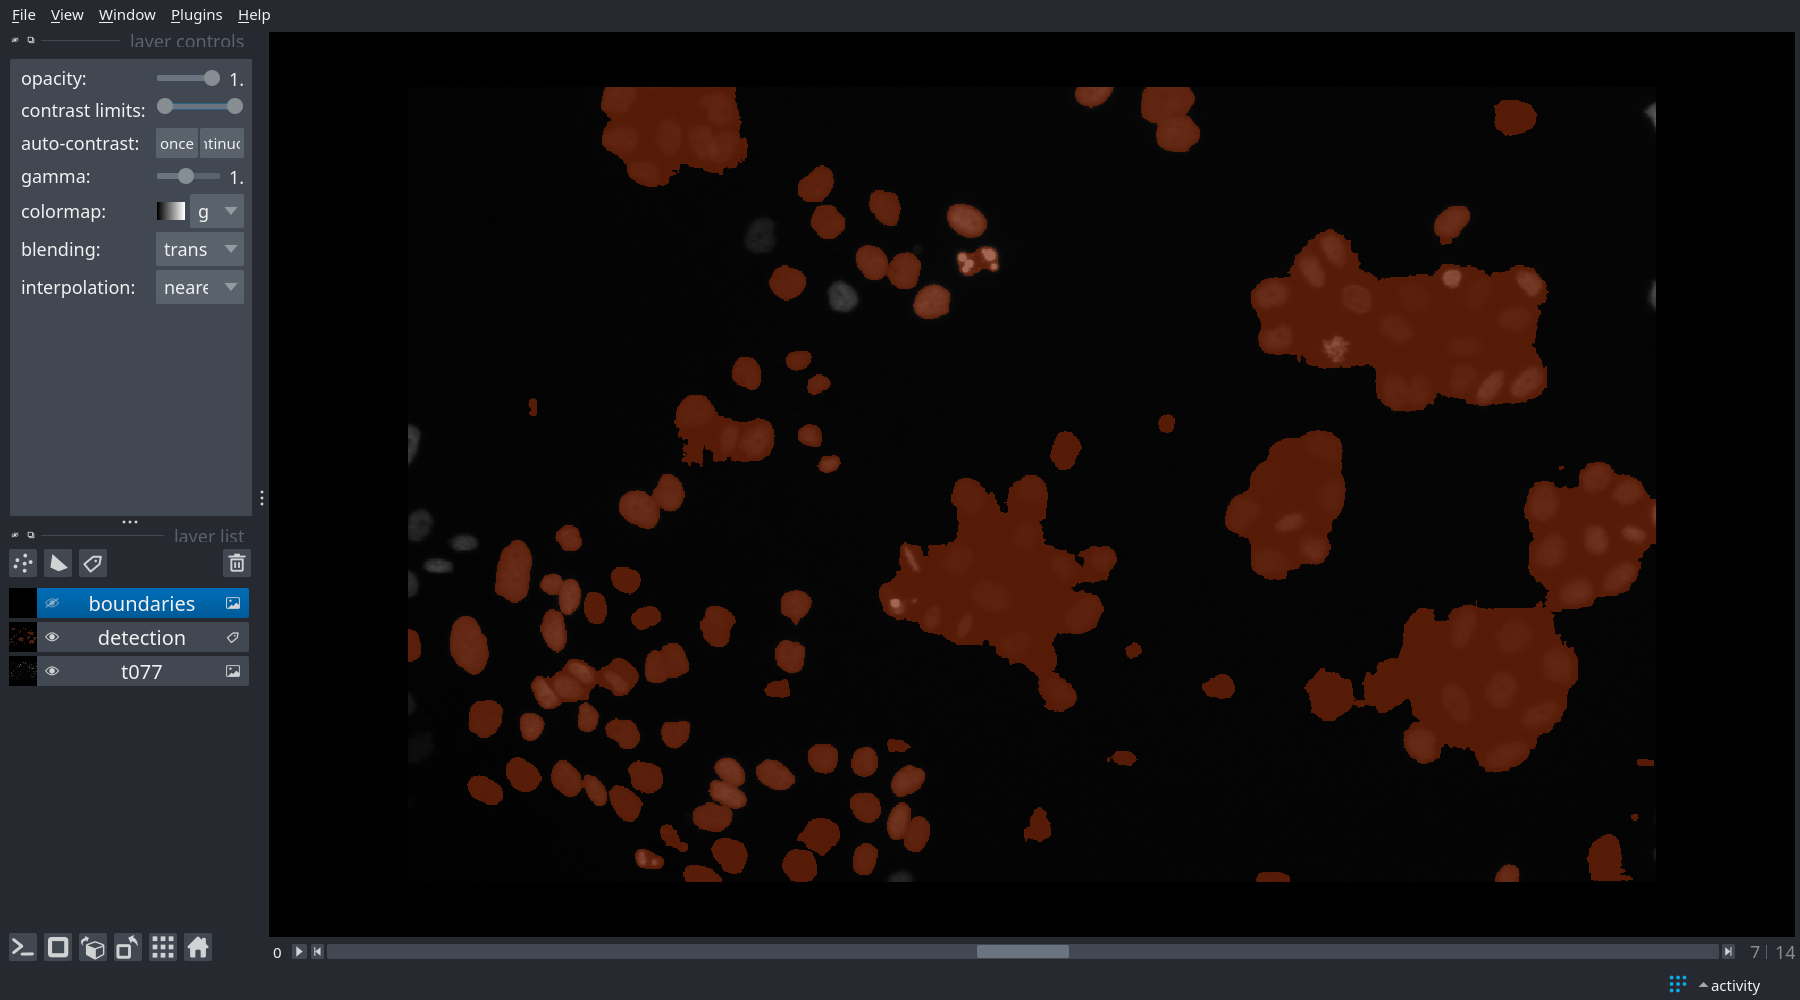

In [4]:
predictor = MicroSAM(
    model_type="vit_h", # "vit_h_lm" is also a valid alternative
    min_mask_region_area=100,
    pred_iou_thresh=0.25,
    stability_score_thresh=0.7,
)

# peak maxima prompt can be used to detect cells in fluorescence images
# comment it to use the default uniform points prompt
predictor = set_peak_maxima_prompt(
    predictor,
    sigma=5.0,
    min_distance=10,
    threshold_rel=0.025,
)

def predict(arr: np.ndarray) -> np.ndarray:
    # normalizing the images before predicting
    norm_arr = normalize(np.asarray(arr), lower_q=0.1, gamma=0.5)
    return predictor(norm_arr)

boundaries = create_zarr(image.shape, np.float16, store_or_path="boundaries.zarr", overwrite=True)
array_apply(
    image,
    out_array=boundaries,
    func=predict,
)

boundaries = da.from_zarr(boundaries)
detection = boundaries >= 0.0

viewer.add_labels(detection)
viewer.add_image(boundaries, visible=False)

nbscreenshot(viewer)

Now that we have our `detection` and `boundaries` you can call the `track` function for the tracking on the contour representation of the cells.

The `track` function is composed of three steps that can also be called individually:
- `segment`: Computes the segmentation hypothesis for tracking;
- `link`: Links and assign edge weights to the segmentation hypothesis;
- `solve`: Solves the tracking problem by selecting the strongly connected segmentation hypothesis.

Each of these steps requires its configuration, which we'll set up below.
The config documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/docs/source/configuration.rst).

In [5]:
config = MainConfig()

config.segmentation_config.min_area = 50
config.segmentation_config.max_area = 950
config.segmentation_config.n_workers = 8

config.linking_config.max_distance = 25
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

print(config)

MainConfig(
    data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
    segmentation_config=SegmentationConfig(
        threshold=0.5,
        min_area=50,
        max_area=950,
        min_frontier=0.0,
        anisotropy_penalization=0.0,
        max_noise=0.0,
        ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fbc7c07bd00>,
        n_workers=8
    ),
    linking_config=LinkingConfig(
        n_workers=8,
        max_neighbors=5,
        max_distance=25,
        distance_weight=0.0,
        z_score_threshold=5.0
    ),
    tracking_config=TrackingConfig(
        appear_weight=-1,
        disappear_weight=-1,
        division_weight=-0.1,
        dismiss_weight_guess=None,
        include_weight_guess=None,
        window_size=None,
        overlap_size=1,
        solution_gap=0.0,
        time_limit=36000,
        method=0,
        n_threads=-1,
        link_function='power',
        power=4,
        bias=-0.001
    )
)

Now, we only need to execute the `track` functions with the configuration we just created and the input images.

In [6]:
track(
    detection=detection,
    edges=boundaries,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|███████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 13149 rows, 22847 columns and 45371 nonzeros
Model fingerprint: 0x974bf476
Variable types: 0 continuous, 22847 integer (22847 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 12782 rows and 22136 columns
Presolve time: 0.51s
Presolved: 367 rows, 711 columns, 1531 nonzeros
Found heuristic solution: objective 630.3203082
Variable types: 0 continuous, 711 integer (711 binary)

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Ba

The`to_tracks_layer` and `tracks_to_zarr` export the solution into a napari compatible format.

Exporting segmentation masks: 100%|█████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.86it/s]


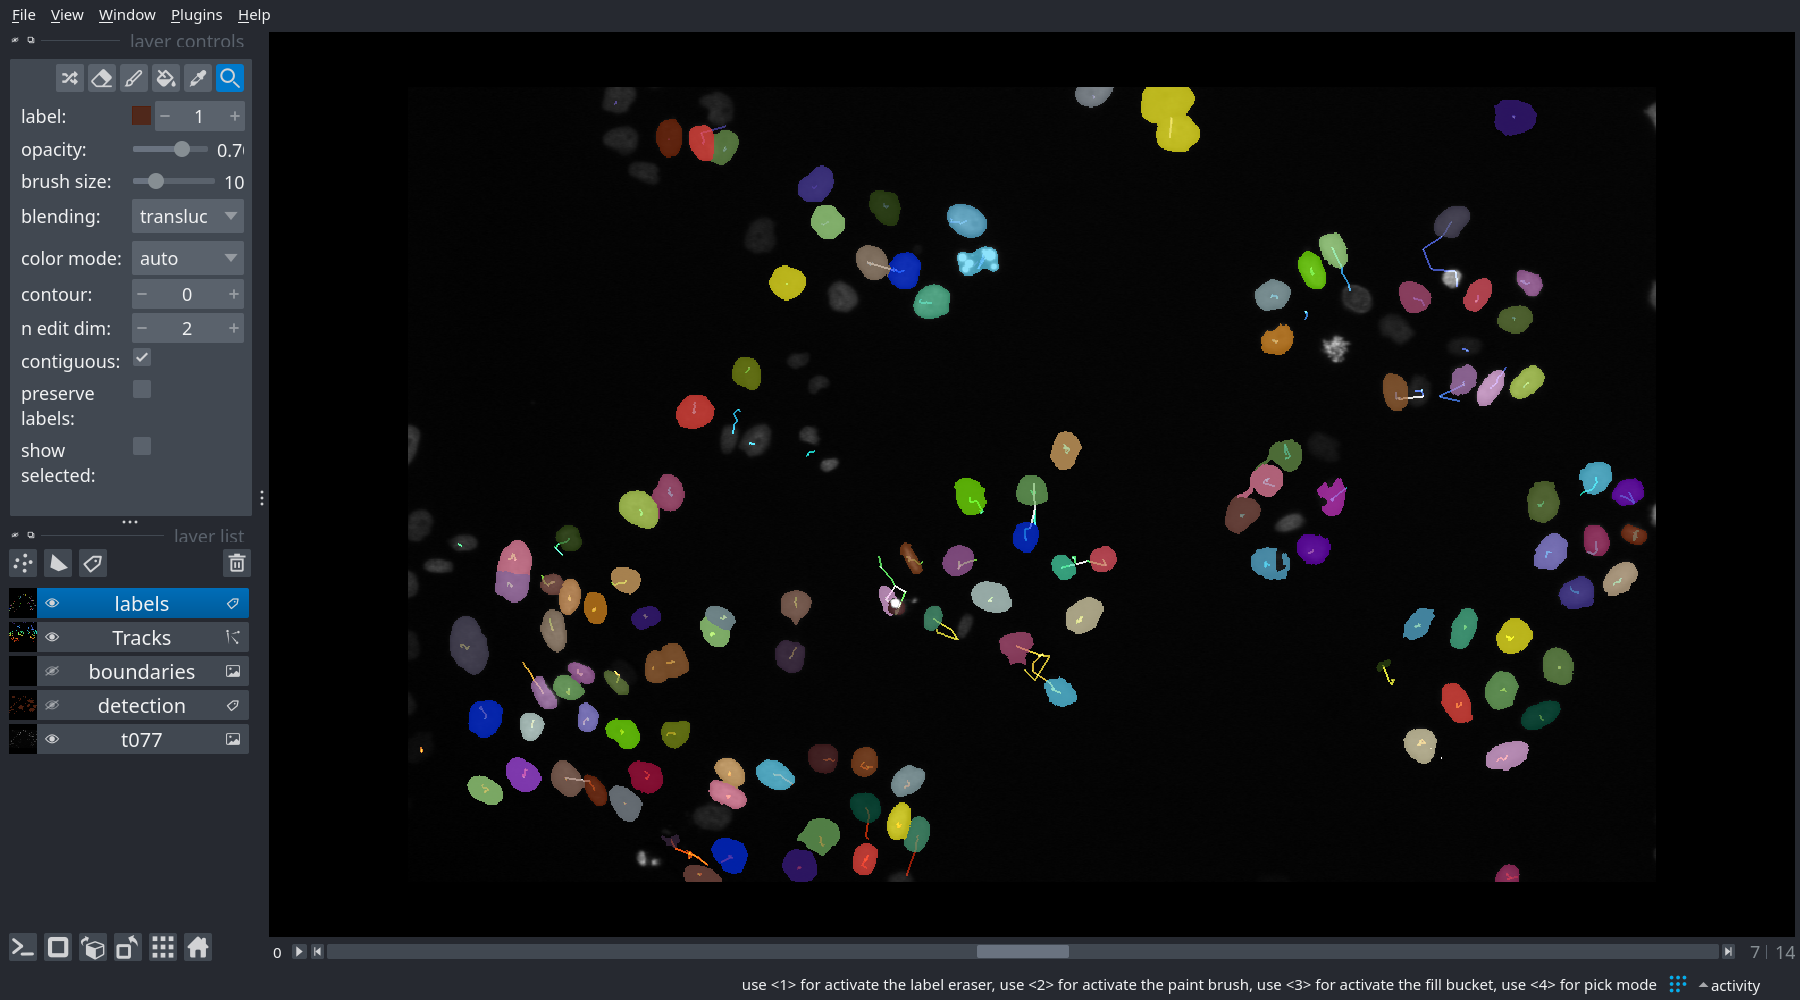

In [7]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["detection"].visible = False

nbscreenshot(viewer)